# 1. Chargement du dataset utkface

In [7]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import kagglehub
import torch.nn as nn
import torchvision.models as models

# Télécharger le dataset UTKFace via KaggleHub (exemple: "jangedoo/utkface-new")
path = kagglehub.dataset_download("jangedoo/utkface-new")
# Supposons que les images sont extraites dans le dossier "UTKFace"
utkface_dir = os.path.join(path, "UTKFace")

# Transformation utilisée pour le test (identique à celle du classifieur multi-tâche)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Pour le classifieur multi-tâche, on utilise la normalisation ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Classe Dataset pour UTKFace
# Les images sont nommées "age_gender_race_date.jpg"
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Répertoire contenant les images UTKFace.
            transform (callable, optionnel): Transformations à appliquer.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg', '.png'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img_path = os.path.join(self.root_dir, filename)
        image = Image.open(img_path).convert("RGB")
        # Extraire l'âge à partir du nom de fichier (premier élément)
        parts = filename.split('_')
        age = float(parts[0])
        if self.transform:
            image = self.transform(image)
        return image, age, filename

# Test rapide du dataset
dataset = UTKFaceDataset(root_dir=utkface_dir, transform=test_transform)
print(f"Nombre d'images dans UTKFace: {len(dataset)}")


Nombre d'images dans UTKFace: 23708


In [8]:
print(dataset[0][0].shape)

torch.Size([3, 224, 224])


# 2. Chargement du classifieur 

In [9]:
class ResNetMultiTask(nn.Module):
    def __init__(self):
        super(ResNetMultiTask, self).__init__()
        # Charger ResNet50 pré-entraîné et remplacer la dernière couche
        self.backbone = models.resnet50(pretrained=True)
        # On remplace la couche fc par une identité pour obtenir le vecteur de features
        self.backbone.fc = nn.Identity()  # La sortie aura 2048 dimensions
        
        # Tête pour la régression d'âge
        self.age_regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
        # Tête pour la classification du genre (2 classes)
        self.gender_classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        features = self.backbone(x)  # (B, 2048)
        age = self.age_regressor(features)       # (B, 1)
        gender = self.gender_classifier(features)  # (B, 2)
        return age, gender

# Définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancier et charger le modèle multi-tâche
clf = ResNetMultiTask().to(device)
# Chargez le modèle pré-entraîné (modifiez le chemin si nécessaire)
clf.load_state_dict(torch.load("resnet_multitask_utkface.pth", map_location=device))
clf.eval()

print("Classifieur multi-tâche chargé et prêt à l'emploi.")

c:\Users\jules\miniconda3\envs\inf554\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jules\miniconda3\envs\inf554\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classifieur multi-tâche chargé et prêt à l'emploi.


# 3. Visualisations

## 3.1 Tests sur des images utkface

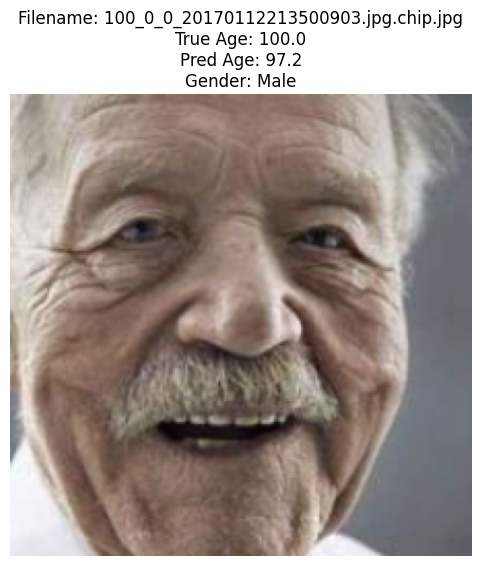

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Charger la première image du dataset
# On utilise directement l'indexation du dataset
image, true_age, filename = dataset[0]
# Ajouter une dimension batch
image_tensor = image.unsqueeze(0).to(device)

# Prédiction avec le modèle multi-tâche
with torch.no_grad():
    age_reg_pred, gender_pred = clf(image_tensor)

# Pour l'âge, on utilise la branche de régression
age_pred = age_reg_pred.item()

# Pour le genre, obtenir la classe prédite (0: Male, 1: Female)
gender_class = torch.argmax(gender_pred, dim=1).item()
gender_label = "Male" if gender_class == 0 else "Female"

# Préparation de l'image pour l'affichage : inverse de la normalisation ImageNet
# L'image est sous forme de tenseur (C, H, W)
image_np = image.cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

# Affichage
plt.figure(figsize=(6,6))
plt.imshow(image_np)
plt.title(f"Filename: {filename}\nTrue Age: {true_age:.1f}\nPred Age: {age_pred:.1f}\nGender: {gender_label}")
plt.axis("off")
plt.show()

## 3.2 Tests sur de nouvelles images

Predicted Age: 38.4 years
Predicted Gender: Male


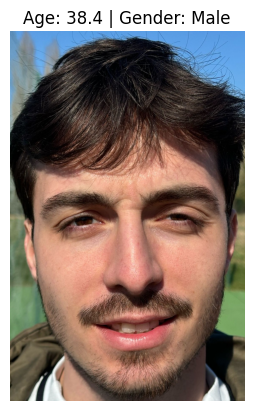

In [16]:
# Transformation de l'image (identique à celle utilisée pour l'entraînement/validation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Charger l'image "Jules.png"
img_path = "MORPH/rodrigue.jpg"  # Assurez-vous que ce fichier se trouve dans le dossier courant
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Ajout d'une dimension batch

# Prédiction avec le modèle
with torch.no_grad():
    age_pred, gender_pred = clf(img_tensor)
predicted_age = age_pred.item()
predicted_gender = torch.argmax(gender_pred, dim=1).item()
gender_str = "Male" if predicted_gender == 0 else "Female"

print(f"Predicted Age: {predicted_age:.1f} years")
print(f"Predicted Gender: {gender_str}")

# Affichage de l'image avec les prédictions
plt.imshow(img)
plt.title(f"Age: {predicted_age:.1f} | Gender: {gender_str}")
plt.axis("off")

plt.show()

# 4. Chargement et test de l'autoencoder simple

In [147]:
import torch
import torch.nn as nn
from torchvision import transforms
import os

# Définition de l'architecture de l'autoencodeur simple
class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # Entrée: (3,224,224) -> (64,112,112)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # (64,112,112) -> (128,56,56)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # (128,56,56) -> (256,28,28)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # (256,28,28) -> (latent_dim,14,14)
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            # (latent_dim,14,14) -> (256,28,28)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # (256,28,28) -> (128,56,56)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # (128,56,56) -> (64,112,112)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # (64,112,112) -> (3,224,224)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Pour obtenir des valeurs dans [-1,1]
        )
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

# Configuration du device et chargement du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_autoencoder = SimpleAutoencoder(latent_dim=256).to(device)

# Assurez-vous que le fichier "simple_autoencoder_utkface.pth" est dans le répertoire courant
simple_autoencoder.load_state_dict(torch.load("simple_autoencoder_utkface.pth", map_location=device))
simple_autoencoder.eval()
print("Modèle simple autoencodeur chargé.")

Modèle simple autoencodeur chargé.


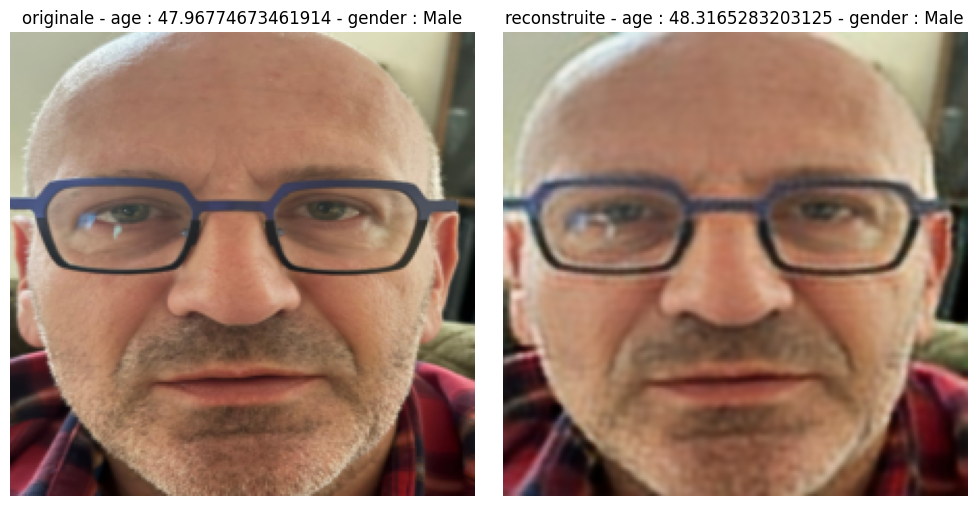

In [160]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Transformation identique à celle utilisée lors de l'entraînement
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Fonction de dé-normalisation pour l'affichage (passage de [-1,1] à [0,1])
def denormalize(tensor):
    tensor = (tensor * 0.5) + 0.5
    return torch.clamp(tensor, 0, 1)

# Charger une image (par exemple "Jules.png")
input_image_path = "MORPH/Christophe.jpg"  # Remplacez par le chemin réel de votre image
original_img = Image.open(input_image_path).convert("RGB")

# Appliquer la transformation et ajouter une dimension batch
input_tensor = transform(original_img).unsqueeze(0).to(device)

# Générer la reconstruction avec l'autoencodeur
with torch.no_grad():
    reconstructed_tensor = simple_autoencoder(input_tensor)

# Préparer les images pour affichage
original_disp = denormalize(input_tensor.squeeze(0)).cpu().permute(1, 2, 0).numpy()
reconstructed_disp = denormalize(reconstructed_tensor.squeeze(0)).cpu().permute(1, 2, 0).numpy()

with torch.no_grad():
    age_pred_input, gender_pred_input = clf(input_tensor)
    age_pred_recon, gender_pred_recon = clf(reconstructed_tensor)

age_pred_input, age_pred_recon = age_pred_input.item(), age_pred_recon.item()
predicted_age = age_pred.item()
predicted_gender = torch.argmax(gender_pred, dim=1).item()
gender_input = "Male" if torch.argmax(gender_pred_input, dim=1).item() == 0 else "Female"
gender_recon = "Male" if torch.argmax(gender_pred_recon, dim=1).item() == 0 else "Female"

# Affichage côte à côte
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_disp)
plt.title(f'originale - age : {age_pred_input} - gender : {gender_input}')

plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(reconstructed_disp)
plt.title(f"reconstruite - age : {age_pred_recon} - gender : {gender_recon}")
plt.axis("off")

plt.tight_layout()
plt.show()
